In [1]:
import os
from PIL import Image
import cv2 as cv
import numpy as np
from matplotlib import pyplot as plt
from skimage.feature.texture import greycoprops, greycomatrix
import pandas as pd
import seaborn as sn
from sklearn.model_selection import train_test_split
from sklearn.metrics import plot_confusion_matrix, classification_report

In [2]:
folder_dataset = 'NEU-CLS'
types = ['RS', 'Pa', 'Cr', 'PS', 'In', 'Sc']
props = ['contrast', 'dissimilarity', 'homogeneity', 'energy', 'correlation', 'ASM']
seed =804

Dataset from [NEU surface defect database](http://faculty.neu.edu.cn/yunhyan/NEU_surface_defect_database.html) y based on paper [Texture Descriptors for Automatic Estimation of Workpiece Quality in Milling](https://link.springer.com/chapter/10.1007/978-3-030-29859-3_62)

In [3]:
files = [file for file in os.listdir(folder_dataset) if file.endswith('.bmp')]
len(files)

1800

In [4]:
def process(id):
    name_file = files[id].split('_')
    data = {'image': files[id], 'type':name_file[0]}
    #Load image
    image = Image.open(folder_dataset+'/'+files[id])
    image = np.array(image)
    #CLAHE
    clahe = cv.createCLAHE(clipLimit=1.0, tileGridSize=(15,15))
    cl1 = clahe.apply(image)
    
    """
    fig, axs = plt.subplots(1, 2)
    axs[0].imshow(image, cmap='gray')
    axs[1].imshow(cl1, cmap='gray')
    plt.show()
    """
    g = greycomatrix(cl1, [1], [0, np.pi/2])
    for prop in props:
        propperty = greycoprops(g, prop)
        data[prop+'_prop'] = propperty[0][0]
        data[prop+'_angle'] = propperty[0][1]
    return data
    
    
df = pd.DataFrame(columns=['image', 'type']+ [prop+'_prop' for prop in props] + [prop+'_angle' for prop in props])
for i in range(0,len(files)):
    data = process(i)
    df = df.append(data, ignore_index=True)

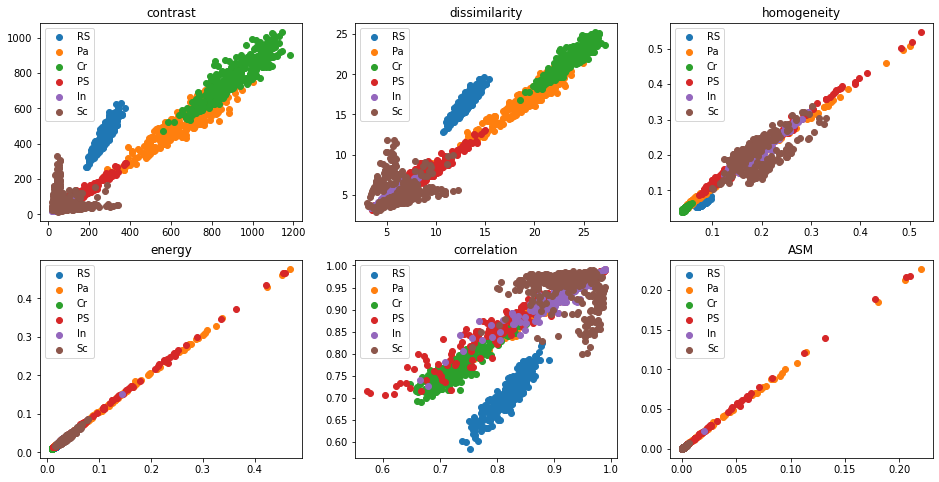

In [5]:
fig, axs = plt.subplots(2, 3, figsize=(16,8))
for type_label in types:
    test = df[df.type==type_label]
    for i in range(0,len(props)):
        axs[int(i/3)][i%3].scatter(test.loc[:,props[i]+"_prop"], test.loc[:,props[i]+"_angle"], label=type_label)
        axs[int(i/3)][i%3].legend()
        axs[int(i/3)][i%3].title.set_text(props[i])
plt.show()

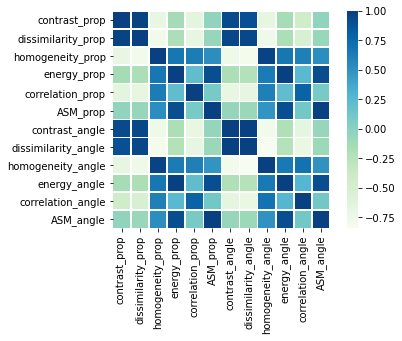

In [6]:
corrMatrix = df.corr()
sn.heatmap(corrMatrix, cmap='GnBu', linewidths=0.5, square=True)
plt.show()

In [7]:
#Prepare data
X_values = df[[prop+'_prop' for prop in props] + [prop+'_angle' for prop in props]]
y_values = df[['type']]
X_train, X_test, y_train, y_test = train_test_split(X_values, y_values, test_size=0.3, random_state=seed)

In [8]:
from sklearn.neighbors import KNeighborsClassifier
neigh = KNeighborsClassifier(n_neighbors=6)
neigh.fit(X_train, y_train.values.ravel())

KNeighborsClassifier(n_neighbors=6)

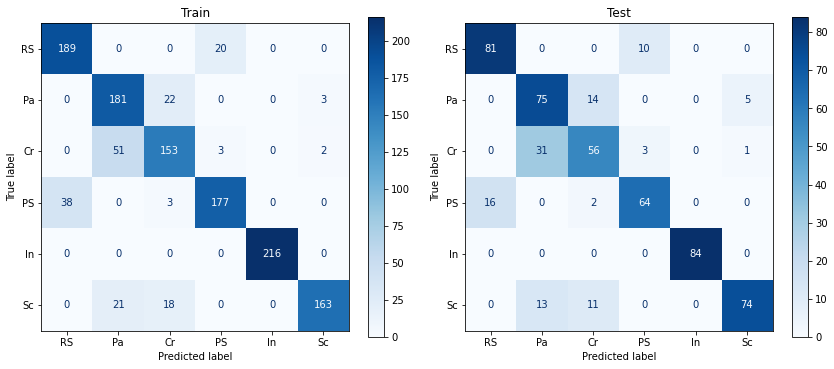

In [9]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,5))
plot_confusion_matrix(neigh,X_train, y_train.values.ravel(),ax=axes[0], cmap='Blues',display_labels=types)
axes[0].title.set_text('Train')
plot_confusion_matrix(neigh,X_test, y_test.values.ravel(),ax=axes[1], cmap='Blues',display_labels=types)
axes[1].title.set_text('Test')
plt.tight_layout()
plt.show()

In [10]:
y_predict_train = neigh.predict(X_train)
print(classification_report(y_train.values.ravel(),y_predict_train, target_names=types))
y_predict = neigh.predict(X_test)
print(classification_report(y_test.values.ravel(),y_predict, target_names=types))

              precision    recall  f1-score   support

          RS       0.83      0.90      0.87       209
          Pa       0.72      0.88      0.79       206
          Cr       0.78      0.73      0.76       209
          PS       0.89      0.81      0.85       218
          In       1.00      1.00      1.00       216
          Sc       0.97      0.81      0.88       202

    accuracy                           0.86      1260
   macro avg       0.86      0.86      0.86      1260
weighted avg       0.86      0.86      0.86      1260

              precision    recall  f1-score   support

          RS       0.84      0.89      0.86        91
          Pa       0.63      0.80      0.70        94
          Cr       0.67      0.62      0.64        91
          PS       0.83      0.78      0.81        82
          In       1.00      1.00      1.00        84
          Sc       0.93      0.76      0.83        98

    accuracy                           0.80       540
   macro avg       0.82